In [2]:
import yaml

In [3]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [4]:
if menu['toolbox']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    import pint
    from pathlib import Path
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from rasterio.plot import show
    from rasterstats import zonal_stats
    from osgeo import gdal, gdalconst
    from scipy.ndimage import generic_filter
    from shapely.geometry import LineString
    from shapely.ops import linemerge, unary_union
    import fiona
    import osmnx as ox
    from shapely.geometry import LineString, mapping
    from skimage import measure
    from shapely.ops import unary_union
    from rasterstats import zonal_stats
    from affine import Affine
    from rasterio.features import geometry_mask
    import fiona
    from rasterio.crs import CRS
    import warnings
    from rasterio.merge import merge 
    from rasterio.transform import from_bounds
    import csv
    from shapely.geometry import LineString, MultiPoint
    from shapely.ops import split, snap
    from rasterio.mask import mask
    import rasterio.features
    from rasterio.enums import Resampling
    from rasterio.vrt import WarpedVRT
    from rasterio.features import shapes
    from shapely.geometry import shape

read AOI shapefile


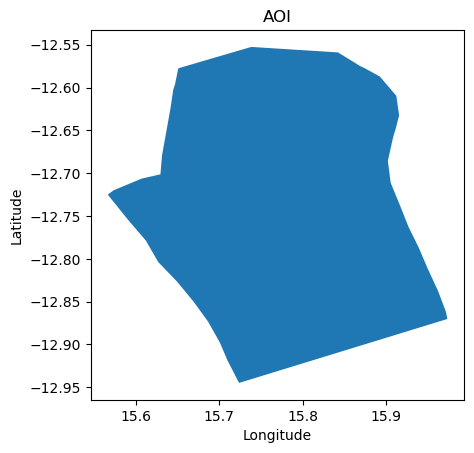

huambo
angola


In [5]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
plot_folder = Path(output_folder/'plots')
pickle_folder = Path(output_folder/'pickles')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print(city)
print(country)

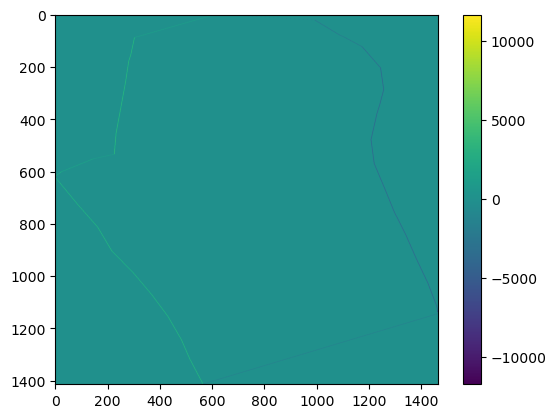

Slope calculation completed and saved to: mnt/city-directories/02-process-output/huambo_slope.tif


In [6]:
#Slope
def get_slope():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    
    if menu['elevation']:  
        elev_path = os.path.join(output_folder, city + '_elevation.tif')
        with rasterio.open(elev_path) as src:
            elev_data = src.read(1)  

            
            slope = np.gradient(elev_data)[1]

            
            plt.imshow(slope, cmap='viridis')
            plt.colorbar()
            plt.show()

            
            slope_path = os.path.join(output_folder, city + "_slope.tif")

            
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)

            
            profile = src.profile
            profile.update({
                'crs': 'EPSG:4326',
                'transform': transform,
                'width': width,
                'height': height
            })

            
            with rasterio.open(slope_path, 'w', **profile) as dst:
    
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)
                
                
                dst.write(slope, 1)

            print("Slope calculation completed and saved to:", slope_path)

get_slope()

In [11]:
#merge pluvial 

def merge_pluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_pluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(pluvial_file) for pluvial_file in matching_files]
        
        try:
            merged_data, merged_transform = merge(src_files_to_merge)
            merged_crs = src_files_to_merge[0].crs
            
            output_file = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
            with rasterio.open(output_file, 'w', driver='GTiff',
                               width=merged_data.shape[2], height=merged_data.shape[1],
                               count=1, dtype=merged_data.dtype,
                               crs=merged_crs, transform=merged_transform) as dst:
                dst.write(merged_data)
    
            print(f"Merged pluvial data saved as {output_file}")
            return output_file
        except Exception as e:
            print(f"Error occurred while merging: {e}")
            return None
    else:
        print("Error: No pluvial files found.")
        return None


merged_pluvial_file = merge_pluvial_files()



Merged pluvial data saved as mnt/city-directories/02-process-output/huambo_merged_pluvial_data.tif


In [12]:
#merge pluvial 

def merge_pluvial_files_UTM():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_pluvial_2020_*_utm.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(pluvial_file) for pluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_pluvial_data_utm.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged pluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No pluvial files found.")
        return None

merged_pluvial_file = merge_pluvial_files_UTM()


Error: No pluvial files found.


In [13]:
def merge_fluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_fluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(fluvial_file) for fluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged fluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No fluvial files found.")
        return None

merged_fluvial_file = merge_fluvial_files()

Merged fluvial data saved as mnt/city-directories/02-process-output/huambo_merged_fluvial_data.tif


In [10]:
def merge_fluvial_files_UTM():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_fluvial_2020_*_utm.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(fluvial_file) for fluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs  # Use the CRS of the first file

        output_file = os.path.join(output_folder, f"{city}_merged_fluvial_data_utm.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged fluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No fluvial files found.")
        return None
    
merged_fluvial_file = merge_fluvial_files_UTM()

Error: No fluvial files found.


In [11]:
#merge comb files and save a merged file  (everything with a value is 1, otherwise 0 )

In [12]:
#merge coastal files and save a merged file  (everything with a value is 1, otherwise 0 )

In [14]:
#resampling data
def resample_raster(input_raster, target_shape):
    # Resample raster to match the target shape
    data = input_raster.read(1, out_shape=target_shape, resampling=Resampling.nearest)
    return data

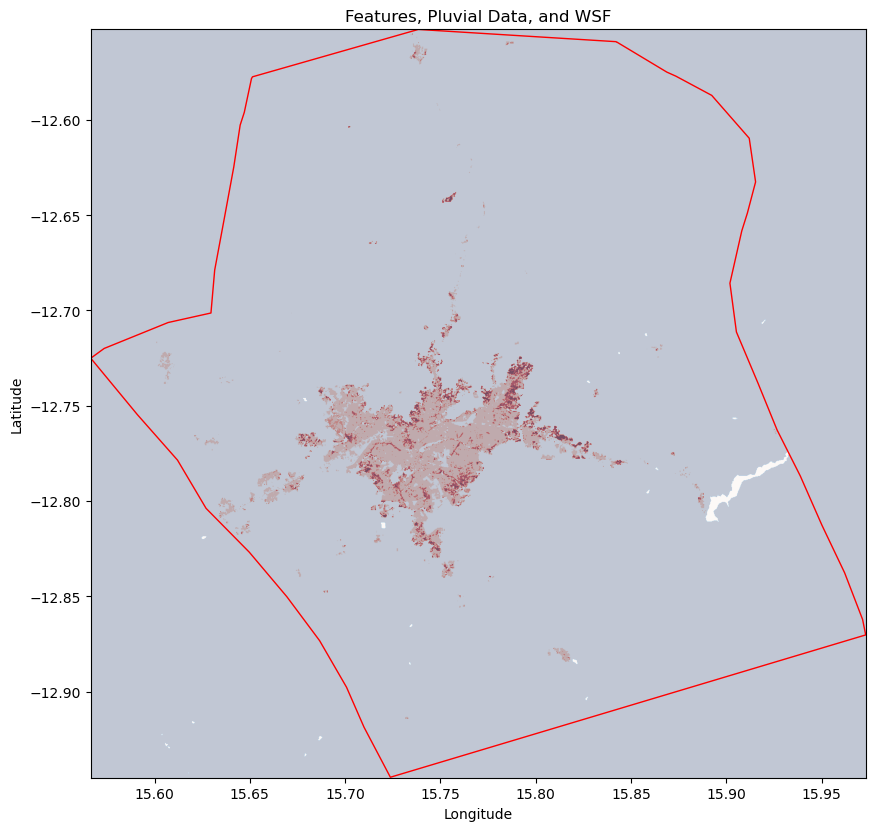

In [19]:
#PLOT CHECK
def plot_data():
    if menu.get('flood_pluvial') and menu.get('wsf'):
        pluvial_path = os.path.join(output_folder, f"{city}_pluvial_2020_1in10.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_4326_reclass.tif")
    # Plot features
    fig, ax = plt.subplots(figsize=(10, 10))
    features.plot(ax=ax, facecolor='none', edgecolor='red')
    

    # Plot pluvial data
    with rasterio.open(pluvial_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot WSF data
    with rasterio.open(wsf_path) as wsf_src:
        show(wsf_src, ax=ax, cmap='Reds', alpha=0.5)

    ax.set_title("Features, Pluvial Data, and WSF")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
plot_data()

Points

In [15]:
#PTs
pu_path = os.path.join(output_folder, f"{city}_fluvial_2020_1in50_con.tif")
with rasterio.open(pu_path) as pu_src:
    merged_pluvial_data = pu_src.read(1)
    merged_pluvial_data_transform = pu_src.transform
    merged_pluvial_data_shape = merged_pluvial_data.shape

stats_list = []

for category in ['PTs']:  
    shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_{category}.shp")
    try:
        amenities = gpd.read_file(shapefile_path)

        with rasterio.open(pu_path) as src:
            affine = src.transform

        stats = zonal_stats(amenities, merged_pluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

        count_overlap = sum([feature["properties"]["count"] for feature in stats])
        total_count = len(amenities)
        percentage = (count_overlap / total_count) * 100

        stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

        print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

    except Exception as e:
        if category == 'PTs':  # Adjusted condition
            print(f"Error processing {category} shapefile: {e}")
        else:
            print("Fire stations do not exist")

df = pd.DataFrame(stats_list)

0 of 89 (0.00%) PTs are located in a riverine flood risk zone with a minimum depth of 15 cm.


In [49]:
#PTs_Summer over 35
sum_path = os.path.join(output_folder, f"{city}_summer_35.tif")
with rasterio.open(sum_path) as sum_src:
    summer35_data = sum_src.read(1)
    summer35_data_transform = sum_src.transform
    

stats_list = []

for category in ['PTs']:  
    shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_{category}.shp")
    try:
        amenities = gpd.read_file(shapefile_path)

        with rasterio.open(pu_path) as src:
            affine = src.transform

        stats = zonal_stats(amenities, summer35_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

        count_overlap = sum([feature["properties"]["count"] for feature in stats])
        total_count = len(amenities)
        percentage = (count_overlap / total_count) * 100

        stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

        print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in areas with summer temperatures over 35.")

    except Exception as e:
        if category == 'PTs':  # Adjusted condition
            print(f"Error processing {category} shapefile: {e}")
        else:
            print("PTs do not exist")

df = pd.DataFrame(stats_list)


0 of 89 (0.00%) PTs are located in areas with summer temperatures over 35.


In [83]:
#PTs
pu_path = os.path.join(output_folder, f"{city}_pop_80.tif")
with rasterio.open(pu_path) as pu_src:
    merged_pluvial_data = pu_src.read(1)
    merged_pluvial_data_transform = pu_src.transform
    merged_pluvial_data_shape = merged_pluvial_data.shape

stats_list = []

for category in ['PTs']:  
    shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_{category}.shp")
    try:
        amenities = gpd.read_file(shapefile_path)

        with rasterio.open(pu_path) as src:
            affine = src.transform

        stats = zonal_stats(amenities, merged_pluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

        count_overlap = sum([feature["properties"]["count"] for feature in stats])
        total_count = len(amenities)
        percentage = (count_overlap / total_count) * 100

        stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

        print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in highly populated areas.")

    except Exception as e:
        if category == 'PTs':  # Adjusted condition
            print(f"Error processing {category} shapefile: {e}")
        else:
            print("Fire stations do not exist")

df = pd.DataFrame(stats_list)

4 of 89 (4.49%) PTs are located in highly populated areas.


Pluvial

0.24627514258615585
0.24764925660994266
Total length of 15 kv intersecting pluvial data: 0.25 meters
Percentage of 15kv lines intersecting pluvial data: 99.4451%


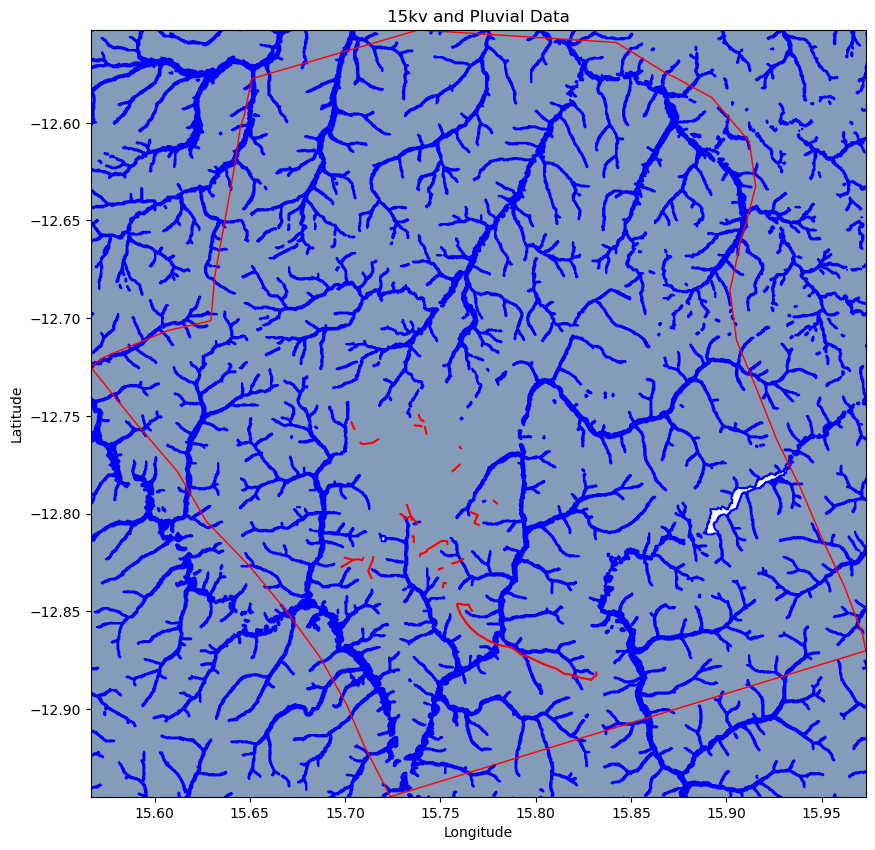

In [85]:

def get_pu_15kv():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_1in10.tif")
    line_path = os.path.join(output_folder, f"{city}_15kv", f"{city}_15kv.shp")

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        lines = gpd.read_file(line_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    lines = lines.to_crs(pluvial_geometry.crs)
    exploded_lines = lines.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_lines, pluvial_geometry, how='intersection')
    
    total_length = sum(geometry.length for geometry in intersections.geometry)
    print(total_length)

    total_length_lines = sum(geometry.length for geometry in lines.geometry if geometry is not None)
    print(total_length_lines)

    percentage = (total_length / total_length_lines) * 100
    
    print(f"Total length of 15 kv intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of 15kv lines intersecting pluvial data: {percentage:.4f}%")

    # Plot pluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot pluvial roads
    exploded_lines.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    # Set plot extent to the bounding box of features
    xmin, ymin, xmax, ymax = features.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title("15kv and Pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

get_pu_15kv()


0.6969309267403274
0.6969309267403277
Total length of 30kv intersecting pluvial data: 0.70 meters
Percentage of 30kv lines intersecting pluvial data: 100.0000%


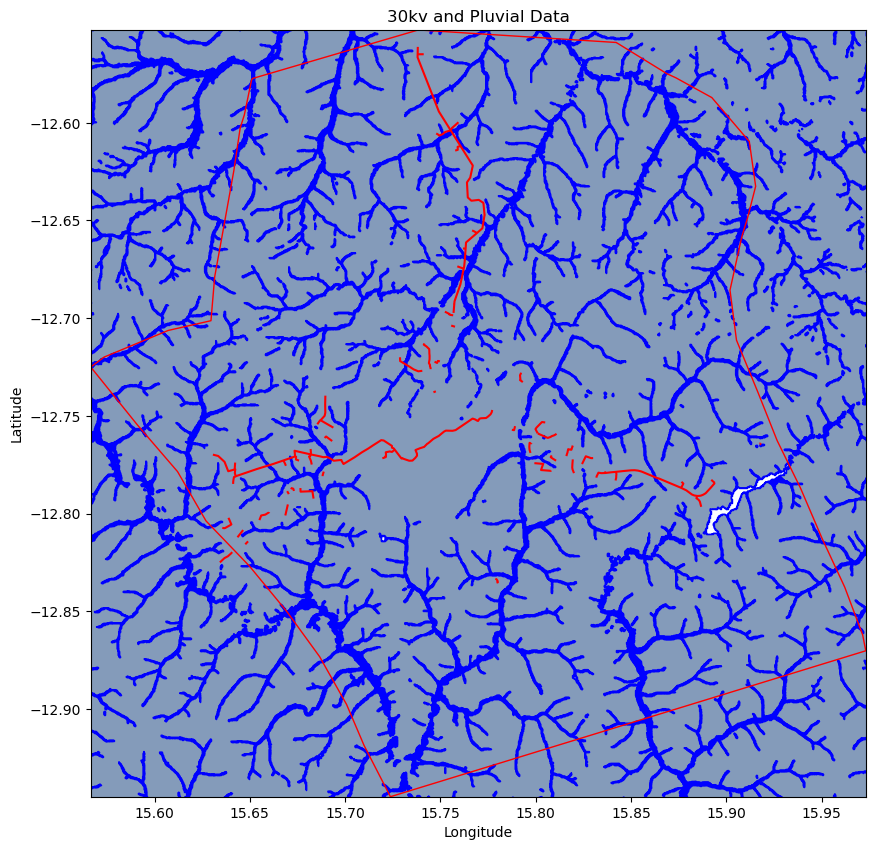

In [58]:

def get_pu_30kv():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_1in10.tif")
    line_path = os.path.join(output_folder, f"{city}_30kv", f"{city}_30kv.shp")

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        lines = gpd.read_file(line_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    lines = lines.to_crs(pluvial_geometry.crs)
    exploded_lines = lines.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_lines, pluvial_geometry, how='intersection')
    
    total_length = sum(geometry.length for geometry in intersections.geometry)
    print(total_length)

    total_length_lines = sum(geometry.length for geometry in lines.geometry if geometry is not None)
    print(total_length_lines)

    percentage = (total_length / total_length_lines) * 100
    
    print(f"Total length of 30kv intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of 30kv lines intersecting pluvial data: {percentage:.4f}%")

    # Plot pluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot pluvial roads
    exploded_lines.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    # Set plot extent to the bounding box of features
    xmin, ymin, xmax, ymax = features.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title("30kv and Pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

get_pu_30kv()


0.24627514258615585
0.24764925660994266
Total length of 15 kv intersecting pluvial data: 0.25 meters
Percentage of 15kv lines intersecting pluvial data: 99.4451%


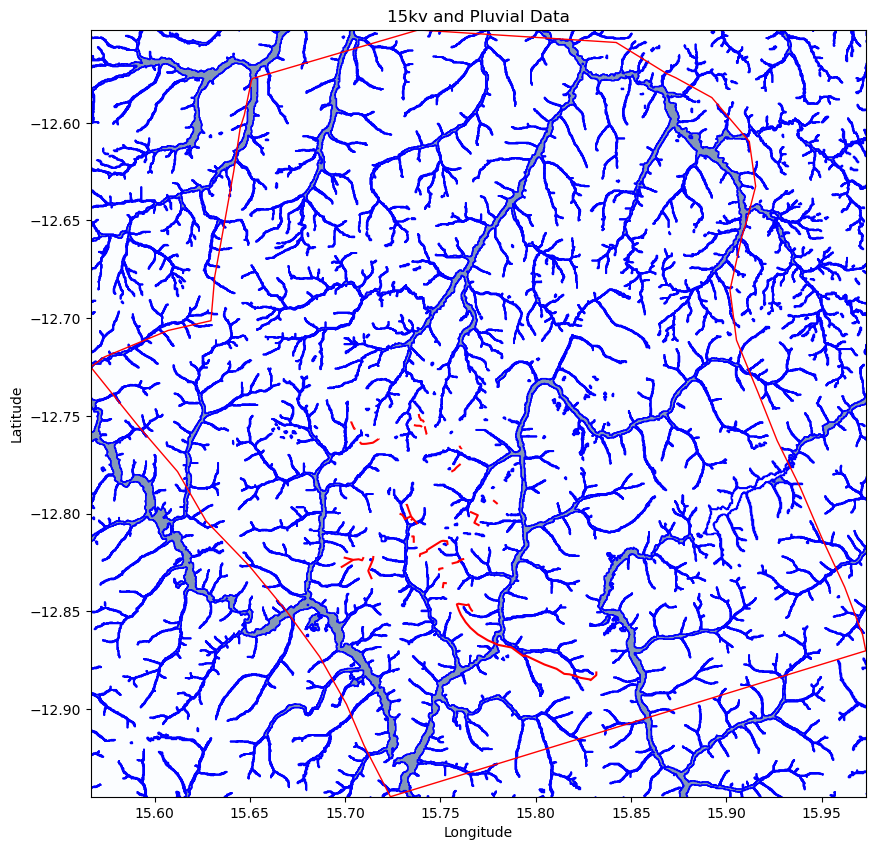

In [79]:

def get_pu_15kv():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_1in50_binary.tif")
    line_path = os.path.join(output_folder, f"{city}_15kv", f"{city}_15kv.shp")

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        lines = gpd.read_file(line_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    lines = lines.to_crs(pluvial_geometry.crs)
    exploded_lines = lines.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_lines, pluvial_geometry, how='intersection')
    
    total_length = sum(geometry.length for geometry in intersections.geometry)
    print(total_length)

    total_length_lines = sum(geometry.length for geometry in lines.geometry if geometry is not None)
    print(total_length_lines)

    percentage = (total_length / total_length_lines) * 100
    
    print(f"Total length of 15 kv intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of 15kv lines intersecting pluvial data: {percentage:.4f}%")

    # Plot pluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot pluvial roads
    exploded_lines.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    # Set plot extent to the bounding box of features
    xmin, ymin, xmax, ymax = features.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title("15kv and Pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

get_pu_15kv()


0.6969309267403276
0.6969309267403277
Total length of 30kv intersecting pluvial data: 0.70 meters
Percentage of 30kv lines intersecting pluvial data: 100.0000%


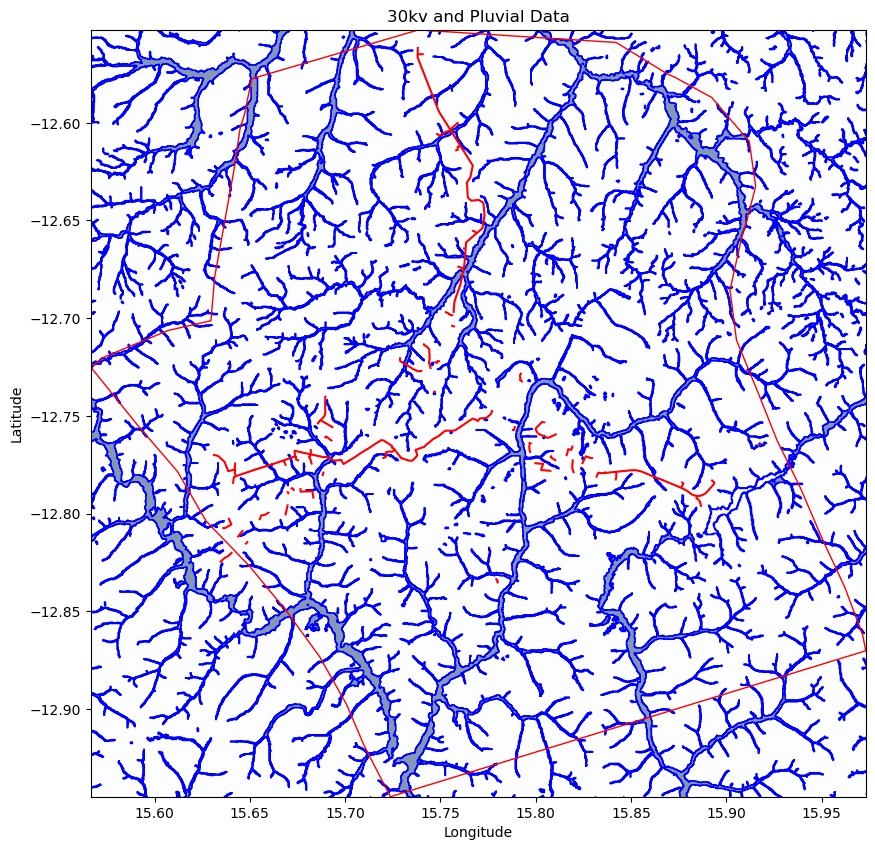

In [62]:

def get_pu_30kv():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_1in50_binary.tif")
    line_path = os.path.join(output_folder, f"{city}_30kv", f"{city}_30kv.shp")

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        lines = gpd.read_file(line_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    lines = lines.to_crs(pluvial_geometry.crs)
    exploded_lines = lines.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_lines, pluvial_geometry, how='intersection')
    
    total_length = sum(geometry.length for geometry in intersections.geometry)
    print(total_length)

    total_length_lines = sum(geometry.length for geometry in lines.geometry if geometry is not None)
    print(total_length_lines)

    percentage = (total_length / total_length_lines) * 100
    
    print(f"Total length of 30kv intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of 30kv lines intersecting pluvial data: {percentage:.4f}%")

    # Plot pluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot pluvial roads
    exploded_lines.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    # Set plot extent to the bounding box of features
    xmin, ymin, xmax, ymax = features.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title("30kv and Pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

get_pu_30kv()


Fluvial

0.2462751425861558
0.24764925660994266
Total length of 15 kv intersecting pluvial data: 0.25 meters
Percentage of 15kv lines intersecting pluvial data: 99.4451%


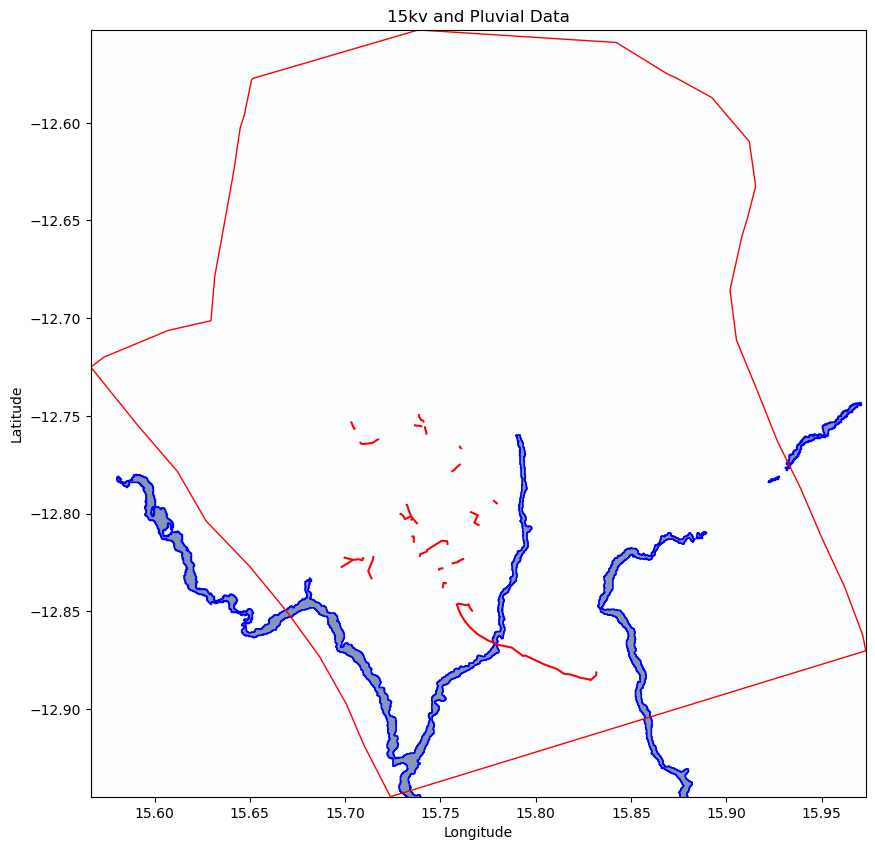

In [63]:

def get_pu_15kv():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_fluvial_2020_1in50_binary.tif")
    line_path = os.path.join(output_folder, f"{city}_15kv", f"{city}_15kv.shp")

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        lines = gpd.read_file(line_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    lines = lines.to_crs(pluvial_geometry.crs)
    exploded_lines = lines.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_lines, pluvial_geometry, how='intersection')
    
    total_length = sum(geometry.length for geometry in intersections.geometry)
    print(total_length)

    total_length_lines = sum(geometry.length for geometry in lines.geometry if geometry is not None)
    print(total_length_lines)

    percentage = (total_length / total_length_lines) * 100
    
    print(f"Total length of 15 kv intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of 15kv lines intersecting pluvial data: {percentage:.4f}%")

    # Plot pluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot pluvial roads
    exploded_lines.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    # Set plot extent to the bounding box of features
    xmin, ymin, xmax, ymax = features.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title("15kv and Pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

get_pu_15kv()


In [51]:
# Fu Amenities

def get_fu_am():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood_fluvial') and menu.get('amenities'):  
        fu_path = os.path.join(output_folder, f"{city}_fluvial_2020_1in10.tif")
        try:
            with rasterio.open(fu_path) as fu_src:
                merged_fluvial_data = fu_src.read(1)
                merged_fluvial_transform = fu_src.transform
                merged_fluvial_shape = merged_fluvial_data.shape
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return

        
        stats_list = []
        for category in ['PTs']:
            shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_osm_{category}.shp")
            try:
                amenities = gpd.read_file(shapefile_path)

                with rasterio.open(fu_path) as src:
                    affine = src.transform

                stats = zonal_stats(amenities, merged_fluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

                count_overlap = sum([feature["properties"]["count"] for feature in stats])
                total_count = len(amenities)
                percentage = (count_overlap / total_count) * 100

                stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

                print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

            except Exception as e:
                if category == 'fire':
                    print("Fire stations do not exist")
                else:
                    print(f"Error processing {category} shapefile: {e}")
        
        df = pd.DataFrame(stats_list)
        
        
        excel_file = os.path.join(output_folder, 'fu_osmpt.xlsx')
        df.to_excel(excel_file, index=False)
        print(f"Statistics saved to {excel_file}")

# Suppress warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

get_fu_am()


In [ ]:
#Comb WSF

In [ ]:
#Comb Population

In [ ]:
#Comb Amenities

In [ ]:
#Coastal WSF

In [ ]:
#Coastal Population

In [ ]:
#Coastal Amenities

In [90]:
# DETERMINE WHETHER TO RUN THIS SCRIPT ##############
import yaml

# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

if menu['accessibility']:
    print('run accessibility')
    
    from os.path import exists
    import os, sys
    import geopandas as gpd
    import osmnx as ox
    import networkx as nx
    from shapely.geometry import box
    from pathlib import Path
    import pickle

    # SET UP #########################################
    # load city inputs files, to be updated for each city scan
    with open("../mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
        city_inputs = yaml.safe_load(f)

    city_name_l = city_inputs['city_name'].replace(' ', '_').lower()

    # load global inputs, such as data sources that generally remain the same across scans
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # import GOSTnets -----------
    sys.path.append(global_inputs['gostnets_path'])
    import GOSTnets as gn
    from GOSTnets.fetch_pois import OsmObject  # TODO: fix GOSTnets

    # Read AOI shapefile --------
    # transform the input shp to correct prj (epsg 4326)
    aoi_orig = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
    # buffer AOI by 5% of its width to capture roads immedately outside of city boundaries
    # TODO: determine whether to put this 5% buffer distance in one of the yaml files
    buff_dist = (aoi_orig.total_bounds[2] - aoi_orig.total_bounds[0]) * 0.05
    aoi_file = aoi_orig.buffer(buff_dist)
    features = aoi_file.geometry
    
    # Define output folder ---------
    output_folder = Path('output')

    if not exists(output_folder):
        os.mkdir(output_folder)


    # EXTRACT OSM POI ##############################
    queries = {}
    if ('osm_query' in city_inputs) and bool(city_inputs['osm_query']):
        for tags in city_inputs['osm_query'].items():
            if not exists(output_folder / f'{city_name_l}_osm_{tags[0]}' / f'{city_name_l}_osm_{tags[0]}.shp'):
                # create the OsmObject
                queries[tags[0]] = OsmObject(f'{tags[0]}', features[0], tags[1])
    
    if bool(global_inputs['osm_query']):
        for tags in global_inputs['osm_query'].items():
            if not tags[0] in queries:
                if not exists(output_folder / f'{city_name_l}_osm_{tags[0]}' / f'{city_name_l}_osm_{tags[0]}.shp'):
                    # create the OsmObject
                    queries[tags[0]] = OsmObject(f'{tags[0]}', features[0], tags[1])
    
    for query in queries.items():
        try:
            result = query[1].GenerateOSMPOIs()
        
            # if query is not empty
            if result.empty == False:
                # try:
                query[1].RemoveDupes(0.0005)
                
                if 'name' in query[1].df.columns:
                    query_results = query[1].df[['amenity','geometry','name']]
                else:
                    query_results = query[1].df[['amenity','geometry']]

                # convert to GeoDataFrame
                query_results_gpd = gpd.GeoDataFrame(query_results, crs = "epsg:4326", geometry = 'geometry')
                query_results_gpd_shp = f'{city_name_l}_osm_{query[0]}'
                if not exists(output_folder / query_results_gpd_shp):
                    os.mkdir(output_folder / query_results_gpd_shp)
                query_results_gpd.to_file(output_folder / query_results_gpd_shp / f'{query_results_gpd_shp}.shp')
        except:
            pass


    # PROCESS ROADS ##############################
    road_graph = output_folder / f"{city_name_l}_osm_roads.pickle"

    if not exists(road_graph):
        extent = box(*aoi_file.total_bounds)
        G = ox.graph_from_polygon(extent, network_type = 'drive_service')
        # This is how time is calculated from the OSMNX length attribute
        G = gn.convert_network_to_time(G, 'length')  # default walk_speed = 4.5 (km/h)
        # save the largest subgraph
    
        # compatible with NetworkX 2.4
        list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
        max_graph = None
        max_edges = 0
        for i in list_of_subgraphs:
            if i.number_of_edges() > max_edges:
                max_edges = i.number_of_edges()
                max_graph = i

        # set graph equal to the largest sub-graph
        G = max_graph

        with open(road_graph, 'wb') as f:
            pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    else:
        with open(road_graph, 'rb') as f:
            G = pickle.load(f)
        
        G = gn.convert_network_to_time(G, 'length')

    roads = gn.edge_gdf_from_graph(G)

    def replace_hwy(x):
        if isinstance(x, list):
            x = x[0]
        return x

    roads['highway'] = roads.apply(lambda x: replace_hwy(x['highway']), axis = 1)

    if not exists(output_folder / f'{city_name_l}_osm_roads' / f'{city_name_l}_osm_roads.shp'):
        roads = roads[['length','time','mode','geometry']]
        roads_shp = f'{city_name_l}_osm_roads'
        if not exists(output_folder / roads_shp):
            os.mkdir(output_folder / roads_shp)
        roads.to_file(output_folder / roads_shp / f'{roads_shp}.shp')


    # COMPILE ISOCHRONE DICTIONARY #################
    if ('isochrone' in city_inputs) and bool(city_inputs['isochrone']):
        isochrones = city_inputs['isochrone']
    elif bool(global_inputs['isochrone']):
        isochrones = global_inputs['isochrone']
    else:
        print('No isochrone parameters found. Ending accessibility analysis.')
        quit()


    # SNAP POI TO ROADS ############################
    snapped_destinations_dict = {}
    for results_gpd in global_inputs['isochrone']:
        snapped_destinations = gn.pandana_snap(G, gpd.read_file(output_folder / f'{city_name_l}_osm_{results_gpd}' / f'{city_name_l}_osm_{results_gpd}.shp'))
        snapped_destinations_dict[results_gpd] = list(snapped_destinations['NN'].unique())


    # PROCESS ISOCHRONES ###########################
    # find graph utm zone
    G_utm = gn.utm_of_graph(G)

    def isochrone_processing(amenity_type):
        amenity_threshold_list = global_inputs['isochrone'].get(amenity_type)
        if amenity_threshold_list == None:
            return "Amenity type not found"
        # if no destinations for amenity type exist
        if snapped_destinations_dict.get(amenity_type) == None:
            print(f"no destinations for {amenity_type} exist")
        else:
            for threshold in amenity_threshold_list:
                gdf_out2_shp = f'{city_name_l}_accessibility_{amenity_type}_{threshold}m'
                if not exists(output_folder / gdf_out2_shp / f'{gdf_out2_shp}.shp'):
                    print(threshold)
                    iso_gdf = gn.make_iso_polys(G, snapped_destinations_dict[amenity_type], [threshold], edge_buff = 300, node_buff = 300, weight = 'length', measure_crs = G_utm)
                    dissolved = iso_gdf.dissolve(by = "thresh")
                    gdf_out = dissolved.explode(index_parts = True)
                    gdf_out2 = gdf_out.reset_index()
                    # save file
                    if not exists(output_folder / gdf_out2_shp):
                        os.mkdir(output_folder / gdf_out2_shp)
                    gdf_out2.to_file(output_folder / gdf_out2_shp / f'{gdf_out2_shp}.shp')
            
    for key in global_inputs['isochrone']:
        isochrone_processing(key)